# Importing libraries

In [2]:
import os
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Reshape
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

# Explore data

In [3]:
path = "/kaggle/input/lakh-midi-clean/ABBA" #Focus on abba

In [5]:
#Getting midi files, parse them and create a corpus of all the notes in the ABBA files
all_midis= []
corrupted_song_names = []
for subdir, dirs, files in os.walk(path, topdown=False):
    for i in files:
        if i.endswith(".mid"):
            tr = os.path.join(subdir, i)
            try:
                midi = converter.parse(tr)
                all_midis.append(midi)
                print(f"{i} successfully parsed.")
            except Exception as e:
                corrupted_song_names.append(i)
                print(f"{i} could not be parsed. Corrupted.") #-> Ive_Been_Waiting_For_You.mid ; Voulez_Vous.1.mid


#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        # Get tempo metadata (assuming it's stored in metadata)
        tempo = j.metronomeMarkBoundaries()[0][2].number if j.metronomeMarkBoundaries() else 120  # default 120 BPM
        
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append((str(element.pitch), element.duration.quarterLength, tempo))
                elif isinstance(element, chord.Chord):
                    notes.append((".".join(str(n) for n in element.normalOrder), element.duration.quarterLength, tempo))
                elif isinstance(element, note.Rest):
                    notes.append(("Rest", element.duration.quarterLength, tempo))
    return notes


#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all ABBA midis in the dataset:", len(Corpus))

Mamma_Mia.4.mid successfully parsed.
Hey,_Hey_Helen.mid successfully parsed.
Dance_While_the_Music_Still_Goes_on_.2.mid successfully parsed.
I_Have_a_Dream.3.mid successfully parsed.
Money,_Money,_Money.10.mid successfully parsed.
Fernando.5.mid successfully parsed.
S.O.S.2.mid successfully parsed.
Name_of_the_Game.1.mid successfully parsed.
Thats_Me.1.mid successfully parsed.
Does_Your_Mother_Know.3.mid successfully parsed.
Fernando.11.mid successfully parsed.
I_Have_a_Dream.4.mid successfully parsed.
Im_a_Marionette.mid successfully parsed.
I_Have_a_Dream.6.mid successfully parsed.
Waterloo.6.mid successfully parsed.
Dancing_Queen.5.mid successfully parsed.
Knowing_Me,_Knowing_You.1.mid successfully parsed.
Dancing_Queen.4.mid successfully parsed.
Money,_Money,_Money.1.mid successfully parsed.
Dancing_Queen.8.mid successfully parsed.
Dance_While_the_Music_Still_Goes_on_.3.mid successfully parsed.
Rock_Me.mid successfully parsed.
Why_Did_It_Have_to_Be_Me.mid successfully parsed.
Mamma

In [6]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: [('E-1', 0.5, 133), ('11.3.6', 4.0, 133), ('Rest', 1.5, 133), ('Rest', 2.0, 133), ('B4', Fraction(1, 6), 133), ('11', 1.0, 133), ('3.6', 0.25, 133), ('Rest', 0.25, 133), ('6', 1.0, 133), ('3.8', 0.75, 133), ('B2', 0.5, 133), ('8', 1.0, 133), ('Rest', 0.5, 133), ('A4', 1.25, 133), ('9', 1.0, 133), ('G#2', 0.5, 133), ('A2', 0.5, 133), ('Rest', 0.25, 133), ('8', 4.0, 133), ('G#2', 2.0, 133), ('C#1', 0.5, 133), ('1.4.8', 4.0, 133), ('Rest', 1.5, 133), ('Rest', 0.5, 133), ('G#4', 1.0, 133), ('C#1', 0.5, 133), ('Rest', 1.5, 133), ('Rest', 2.0, 133), ('Rest', 2.0, 133), ('G#4', 0.5, 133), ('B0', 0.5, 133), ('8.11.3', 4.0, 133), ('Rest', 1.0, 133), ('Rest', 1.5, 133), ('8', 1.0, 133), ('G#4', 0.25, 133), ('E-4', 0.75, 133), ('3', 1.0, 133), ('Rest', 0.25, 133), ('B0', 0.5, 133), ('E4', 0.75, 133), ('G#2', 0.5, 133), ('4', 1.0, 133), ('Rest', 0.25, 133), ('6.11', Fraction(1, 3), 133), ('F#4', 0.75, 133), ('Rest', Fraction(1, 6), 133), ('6', 1.0, 133), ('E2', 0.

In [8]:
#To convert list of notes into midi

from music21 import note, chord, stream, tempo  # Added tempo import
from fractions import Fraction

def chords_n_notes(Snippet):
    Melody = []
    offset = 0  # Incremental offset for placement in the stream
    current_tempo = 120  # Default tempo if not specified
    
    for element in Snippet:
        # Check if element is a tuple (pitch, duration, tempo) or just pitch
        if isinstance(element, tuple) and len(element) == 3:
            pitch, duration, current_tempo = element
        else:
            # Handle case where element is just pitch (for backward compatibility)
            pitch = element
            duration = 1.0  # Default duration
            # current_tempo remains unchanged
        
        # If it's a chord (contains dots or is a digit sequence)
        if ("." in str(pitch) or str(pitch).isdigit()):
            chord_notes = str(pitch).split(".")  # Separate the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note(inst_note)
                note_snip.duration.quarterLength = duration
                notes.append(note_snip)
            chord_snip = chord.Chord(notes)
            chord_snip.offset = offset
            chord_snip.duration.quarterLength = duration
            Melody.append(chord_snip)
        
        # If it's a rest
        elif str(pitch) == "Rest":
            rest_snip = note.Rest()
            rest_snip.duration.quarterLength = duration
            rest_snip.offset = offset
            Melody.append(rest_snip)
        
        # If it's a single note
        else:
            note_snip = note.Note(pitch)
            note_snip.duration.quarterLength = duration
            note_snip.offset = offset
            Melody.append(note_snip)
        
        # Increase offset by duration
        offset += duration
    
    # Create a stream and set the tempo
    Melody_midi = stream.Stream(Melody)
    # Create MetronomeMark using the tempo module
    mm = tempo.MetronomeMark(number=current_tempo)
    Melody_midi.insert(0, mm)
    
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
print(Melody_Snippet)

<music21.stream.Stream 0x79724bc53c70>


# Build the training dataset

In [9]:
#Find all unique song names
song_names = []
for subdir, dirs, files in os.walk(path, topdown=False):
    for i in files:
        if i.endswith(".mid"):
            tr = os.path.join(subdir, i)
            first = True
            for c in i:
                try: 
                    int(c)
                    first = False
                except Exception as e:
                    continue
            if (first):
                song_names.append(i)

print(song_names) #Ask chatGPT to write descriptions based on the name of the song (assuming it knows the songs)

['Hey,_Hey_Helen.mid', 'Im_a_Marionette.mid', 'Rock_Me.mid', 'Why_Did_It_Have_to_Be_Me.mid', 'Voulez_Vous.mid', 'Honey_Honey.mid', 'Name_of_the_Game.mid', 'Thats_Me.mid', 'Lay_All_Your_Love_on_Me.mid', 'Waterloo.mid', 'Knowing_Me,_Knowing_You.mid', 'Take_a_Chance_on_Me.mid', 'I_Do,_I_Do,_I_Do,_I_Do.mid', 'Lovers_Live_a_Little_Longer_.mid', 'Does_Your_Mother_Know.mid', 'Ive_Been_Waiting_For_You.mid', 'Move_On.mid', 'Dance_While_the_Music_Still_Goes_on_.mid', 'Thank_You_for_the_Music.mid', 'Summer_Night_City.mid', 'Super_Trouper.mid', 'I_Wonder_Departure_.mid', 'Like_an_Angel_Passing_Through_My_Room.mid', 'Eagle.mid', 'Tiger.mid', 'Gimme_Gimme_Gimme.mid', 'Hasta_Manana.mid', 'Nina_Pretty_Ballerina.mid', 'One_Of_Us.mid', 'The_Visitors.mid', 'The_Winner_Takes_It_All.mid', 'Another_Town,_Another_Train.mid', 'Chiquitita.mid', 'Two_for_the_Price_of_One.mid', 'I_Have_a_Dream.mid', 'Super_Trooper.mid', 'Mamma_Mia.mid', 'Money,_Money,_Money.mid', 'Medley.mid', 'I_Am_the_City.mid', 'Fernando.mid'

In [11]:
#Group midi files by song name
cleaned_song_names = []
for song in song_names:
    if song in corrupted_song_names:
        continue
    else:
        cleaned_song_names.append(song)

song_names = cleaned_song_names
songs = {song: extract_notes([converter.parse(path + "/" + song)]) for song in song_names}


print(songs["Hey,_Hey_Helen.mid"])

[('Rest', 2.0, 118), ('Rest', 0.75, 118), ('Rest', 0.75, 118), ('Rest', 0.25, 118), ('Rest', 0.25, 118), ('Rest', 0.25, 118), ('Rest', 0.25, 118), ('Rest', 0.75, 118), ('Rest', 0.75, 118), ('Rest', 0.25, 118), ('Rest', 0.25, 118), ('Rest', 0.25, 118), ('Rest', 0.25, 118), ('Rest', 0.75, 118), ('Rest', 0.75, 118), ('Rest', 0.25, 118), ('Rest', 0.25, 118), ('Rest', 0.25, 118), ('Rest', 0.25, 118), ('Rest', 2.5, 118), ('Rest', 3.5, 118), ('Rest', 0.75, 118), ('Rest', 0.75, 118), ('Rest', 0.25, 118), ('2.7', 0.5, 118), ('Rest', 0.25, 118), ('4.9', 0.5, 118), ('Rest', 0.25, 118), ('D3', 0.5, 118), ('9.2', 0.5, 118), ('Rest', 0.25, 118), ('Rest', 2.5, 118), ('D3', 1.0, 118), ('9.2', 2.0, 118), ('Rest', 0.75, 118), ('Rest', 0.75, 118), ('Rest', 0.25, 118), ('9.2', 0.5, 118), ('Rest', 0.75, 118), ('Rest', 0.25, 118), ('4.9', 0.5, 118), ('Rest', 0.25, 118), ('G2', 1.5, 118), ('2.7', 2.0, 118), ('Rest', 0.75, 118), ('Rest', 2.25, 118), ('Rest', 0.5, 118), ('Rest', 0.5, 118), ('Rest', 0.25, 118),

In [12]:
#Find the min length of the midi files and use it as max length
max_length = len(songs["Hey,_Hey_Helen.mid"])
print(max_length)
for name, song in songs.items():
    print(f"name : {name}")
    midiLength = len(song)
    if max_length > midiLength:
        max_length = midiLength
        

print(max_length) #5658
        

1563
name : Hey,_Hey_Helen.mid
name : Im_a_Marionette.mid
name : Rock_Me.mid
name : Why_Did_It_Have_to_Be_Me.mid
name : Voulez_Vous.mid
name : Honey_Honey.mid
name : Name_of_the_Game.mid
name : Thats_Me.mid
name : Lay_All_Your_Love_on_Me.mid
name : Waterloo.mid
name : Knowing_Me,_Knowing_You.mid
name : Take_a_Chance_on_Me.mid
name : I_Do,_I_Do,_I_Do,_I_Do.mid
name : Lovers_Live_a_Little_Longer_.mid
name : Does_Your_Mother_Know.mid
name : Move_On.mid
name : Dance_While_the_Music_Still_Goes_on_.mid
name : Thank_You_for_the_Music.mid
name : Summer_Night_City.mid
name : Super_Trouper.mid
name : I_Wonder_Departure_.mid
name : Like_an_Angel_Passing_Through_My_Room.mid
name : Eagle.mid
name : Tiger.mid
name : Gimme_Gimme_Gimme.mid
name : Hasta_Manana.mid
name : Nina_Pretty_Ballerina.mid
name : One_Of_Us.mid
name : The_Visitors.mid
name : The_Winner_Takes_It_All.mid
name : Another_Town,_Another_Train.mid
name : Chiquitita.mid
name : Two_for_the_Price_of_One.mid
name : I_Have_a_Dream.mid
name :

In [13]:
labels = { #by Deepseek
    "Hey,_Hey_Helen.mid": "ABBA 1979 rock mid-tempo",
    "Im_a_Marionette.mid": "ABBA 1977 theatrical dark slow",
    "Rock_Me.mid": "ABBA 1975 rock upbeat fast",
    "Why_Did_It_Have_to_Be_Me.mid": "ABBA 1976 bluesy lively mid-tempo",
    "Honey_Honey.mid": "ABBA 1974 pop cheerful fast",
    "Name_of_the_Game.mid": "ABBA 1977 pop introspective slow",
    "Thats_Me.mid": "ABBA 1976 pop gentle mid-tempo",
    "Lay_All_Your_Love_on_Me.mid": "ABBA 1980 disco intense fast",
    "Waterloo.mid": "ABBA 1974 glam triumphant fast",
    "Knowing_Me,_Knowing_You.mid": "ABBA 1976 ballad melancholic slow",
    "Take_a_Chance_on_Me.mid": "ABBA 1978 pop playful fast",
    "I_Do,_I_Do,_I_Do,_I_Do.mid": "ABBA 1975 ballad vintage slow",
    "Lovers_Live_a_Little_Longer_.mid": "ABBA 1977 disco funky mid-tempo",
    "Does_Your_Mother_Know.mid": "ABBA 1979 rock-n-roll punchy fast",
    "Move_On.mid": "ABBA 1977 pop uplifting mid-tempo",
    "Dance_While_the_Music_Still_Goes_on_.mid": "ABBA 1977 theatrical nostalgic slow",
    "Thank_You_for_the_Music.mid": "ABBA 1977 cabaret charming mid-tempo",
    "Summer_Night_City.mid": "ABBA 1978 disco pulsating fast",
    "Super_Trouper.mid": "ABBA 1980 pop bittersweet mid-tempo",
    "I_Wonder_Departure_.mid": "ABBA 1977 ballad theatrical slow",
    "Like_an_Angel_Passing_Through_My_Room.mid": "ABBA 1981 atmospheric haunting slow",
    "Eagle.mid": "ABBA 1977 progressive mystical mid-tempo",
    "Tiger.mid": "ABBA 1976 pop urgent fast",
    "Gimme_Gimme_Gimme.mid": "ABBA 1979 disco dramatic fast",
    "Hasta_Manana.mid": "ABBA 1973 ballad sentimental slow",
    "Nina_Pretty_Ballerina.mid": "ABBA 1973 pop cheerful fast",
    "One_Of_Us.mid": "ABBA 1981 ballad poignant slow",
    "The_Visitors.mid": "ABBA 1981 electronic eerie mid-tempo",
    "The_Winner_Takes_It_All.mid": "ABBA 1980 ballad emotional slow",
    "Another_Town,_Another_Train.mid": "ABBA 1973 folk wistful mid-tempo",
    "Chiquitita.mid": "ABBA 1979 ballad comforting slow",
    "Two_for_the_Price_of_One.mid": "ABBA 1981 pop quirky fast",
    "I_Have_a_Dream.mid": "ABBA 1979 ballad ethereal slow",
    "Super_Trooper.mid": "ABBA 1980 pop anthemic mid-tempo",
    "Mamma_Mia.mid": "ABBA 1975 pop vibrant fast",
    "Money,_Money,_Money.mid": "ABBA 1976 theatrical dramatic mid-tempo",
    "Medley.mid": "ABBA 1980 pop energetic fast",
    "I_Am_the_City.mid": "ABBA 1982 synth futuristic mid-tempo",
    "Fernando.mid": "ABBA 1976 ballad nostalgic slow",
    "S.O.S.mid": "ABBA 1975 pop dramatic mid-tempo",
    "Dancing_Queen.mid": "ABBA 1976 disco euphoric fast",
    "Kisses_of_Fire.mid": "ABBA 1979 disco sultry fast",
    "Hole_In_Your_Soul.mid": "ABBA 1977 rock electrifying fast",
    "My_Love_My_Life.mid": "ABBA 1976 ballad heartfelt slow",
    "Andante,_Andante.mid": "ABBA 1980 ballad romantic slow",
    "Angeleyes.mid": "ABBA 1979 disco haunting mid-tempo"
}




In [22]:
#Creating the dataset with notes and descriptions
dataset = []
max_length = 100 #small chunks to avoid computational issues
for song, notes in songs.items():
    for name, desc in labels.items():
        if song == name:
            dataset.append({song: (notes[len(notes)//2 - max_length:len(notes)//2 + max_length], desc)}) #taking the middle of the song so it contains its essence
            
#print(len(dataset[1]["Im_a_Marionette.mid"][0]))
print(dataset[6])

{'Thats_Me.mid': ([('8.1', 2.0, 129), ('F4', 1.0, 129), ('E-4', 1.5, 129), ('B3', 2.0, 129), ('F4', 0.5, 129), ('F4', 1.5, 129), ('C#4', 2.0, 129), ('F#4', 0.5, 129), ('F#4', 1.5, 129), ('E-4', 2.0, 129), ('G#4', 0.5, 129), ('8.11.3', 1.0, 129), ('Rest', 2.0, 129), ('11.3.6', 1.0, 129), ('B4', 0.5, 129), ('8.11', 1.0, 129), ('B4', 0.5, 129), ('B4', 0.5, 129), ('8.1', 1.0, 129), ('B4', 0.5, 129), ('B4', 0.5, 129), ('3.8', 1.0, 129), ('B4', 0.5, 129), ('B4', 0.5, 129), ('4.8', 1.0, 129), ('B4', 0.5, 129), ('5.8.11', 1.0, 129), ('5.8.11', 1.0, 129), ('Rest', 1.0, 129), ('6.10.1', 0.5, 129), ('6.10.1', 0.5, 129), ('6.10.1', 1.0, 129), ('Rest', 1.5, 129), ('F4', 0.5, 129), ('F#4', 0.5, 129), ('7.10.1', 0.5, 129), ('7.10.1', 2.0, 129), ('Rest', 2.0, 129), ('B4', 0.5, 129), ('8.11', 1.0, 129), ('B4', 0.5, 129), ('B4', 0.5, 129), ('8.1', 1.0, 129), ('B4', 0.5, 129), ('B4', 0.5, 129), ('3.8', 1.0, 129), ('B4', 0.5, 129), ('B4', 0.5, 129), ('4.8', 1.0, 129), ('B4', 0.5, 129), ('5.8.11', 1.0, 129

# Process the data : tokenize

In [34]:
#We use the Corpus from the beginning, with all the notes in the ABBA folder
#We associate a unique numerical value to each note and create a way to encode or decode


symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

mapping = dict((c, i) for i, c in enumerate(symb)) #encoded
reverse_mapping = dict((i, c) for i, c in enumerate(symb)) #decoded

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 629071
Number of unique characters: 27235


In [35]:
#We tokenize the descriptions for the language model part

from tensorflow.keras.preprocessing.text import Tokenizer

descriptions = list(labels.values())

tokenizer = Tokenizer()
tokenizer.fit_on_texts(descriptions)

text_sequences = tokenizer.texts_to_sequences(descriptions)

print("Vocabulaire :", tokenizer.word_index)
print("\nExemple de séquence :", text_sequences[0])  

Vocabulaire : {'abba': 1, 'fast': 2, 'mid': 3, 'tempo': 4, 'slow': 5, 'pop': 6, 'ballad': 7, '1977': 8, '1976': 9, '1979': 10, 'disco': 11, '1980': 12, 'rock': 13, 'theatrical': 14, '1975': 15, '1981': 16, 'dramatic': 17, '1973': 18, '1974': 19, 'cheerful': 20, '1978': 21, 'nostalgic': 22, 'haunting': 23, 'dark': 24, 'upbeat': 25, 'bluesy': 26, 'lively': 27, 'introspective': 28, 'gentle': 29, 'intense': 30, 'glam': 31, 'triumphant': 32, 'melancholic': 33, 'playful': 34, 'vintage': 35, 'funky': 36, 'n': 37, 'roll': 38, 'punchy': 39, 'uplifting': 40, 'cabaret': 41, 'charming': 42, 'pulsating': 43, 'bittersweet': 44, 'atmospheric': 45, 'progressive': 46, 'mystical': 47, 'urgent': 48, 'sentimental': 49, 'poignant': 50, 'electronic': 51, 'eerie': 52, 'emotional': 53, 'folk': 54, 'wistful': 55, 'comforting': 56, 'quirky': 57, 'ethereal': 58, 'anthemic': 59, 'vibrant': 60, 'energetic': 61, '1982': 62, 'synth': 63, 'futuristic': 64, 'euphoric': 65, 'sultry': 66, 'electrifying': 67, 'heartfelt'

In [36]:
#Finally, the dataset to feed the model

encoded_dataset = []
for i in range(len(dataset)):
    for song, (notes, desc) in dataset[i].items():
        #print(f"song: {song}, notes : {notes}, desc : {desc}")
        notes_encoded = [mapping[note] for note in notes]
        desc_encoded = tokenizer.texts_to_sequences([desc])[0]
    
        encoded_dataset.append((desc_encoded, notes_encoded))


X = []
Y = []

for desc, notes in encoded_dataset:
    X.append(desc)
    Y.append(notes)






In [37]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np


# Padding pour les descriptions et les notes
X_padded = pad_sequences(X, padding='post')  # Padding à la fin des séquences de descriptions
Y_padded = pad_sequences(Y, padding='post')  # Padding à la fin des séquences de notes


# Redimensionner X pour que le LSTM puisse l'utiliser (nombre_d_exemples, timesteps, 1)
X_padded = X_padded.reshape(X_padded.shape[0], X_padded.shape[1], 1) 

#Y_padded = Y_padded.reshape(Y_padded.shape[0], Y_padded.shape[1], 1)
Y_padded = tensorflow.keras.utils.to_categorical(Y_padded) 




# Vérification des dimensions
print("Shape de X:", X_padded.shape)
print("Shape de Y:", Y_padded.shape)

Shape de X: (46, 7, 1)
Shape de Y: (46, 200, 27231)


# Build the model

In [87]:
# Configure for GPU acceleration
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print(f"GPUs available: {len(physical_devices)}")
    
from keras.layers import BatchNormalization, LeakyReLU, Lambda, Conv1DTranspose

from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, LeakyReLU, Dropout, Reshape, Conv1DTranspose, Lambda, TimeDistributed, Attention, Concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, LeakyReLU, Dropout, Reshape, Conv1DTranspose, Lambda, TimeDistributed, Multiply, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform

def build_enhanced_attention_model(input_shape, output_sequence_length, num_features):
    # Encoder
    encoder_input = Input(shape=input_shape)
    
    # Enhanced Encoder with residual connections
    x = LSTM(512, return_sequences=True, kernel_initializer=glorot_uniform())(encoder_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.3)(x)
    
    x = LSTM(256, return_sequences=True, kernel_initializer=glorot_uniform())(x)
    x = BatchNormalization()(x)
    encoder_output = LSTM(128, return_sequences=True, kernel_initializer=glorot_uniform())(x)
    
    # Improved Attention Mechanism (Bahdanau-style)
    attention = Dense(128, activation='tanh')(encoder_output)
    attention = Dense(1, activation='relu')(attention)
    attention = Activation('softmax', name='attention_weights')(attention)  # Across time steps
    context = Multiply()([encoder_output, attention])
    
    # Residual connection with attention
    context = Add()([encoder_output, context])
    
    # Decoder with enhanced capacity
    x = LSTM(256, return_sequences=False)(context)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # Projection with skip connection
    projected = Dense(output_sequence_length * 256)(x)
    projected = Reshape((output_sequence_length, 256))(projected)
    
    # Upsampling with skip connections
    x = Conv1DTranspose(256, kernel_size=5, padding='same', kernel_initializer=glorot_uniform())(projected)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Add()([x, projected])  # Skip connection
    
    x = Conv1DTranspose(128, kernel_size=5, padding='same', kernel_initializer=glorot_uniform())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    # Temperature scaling
    x = Lambda(lambda x: x / 0.3)(x)
    
    # Output with learned initial bias
    output = TimeDistributed(
        Dense(num_features, activation='softmax', 
              bias_initializer='glorot_uniform')
    )(x)
    
    return Model(encoder_input, output)

# Build model
model = build_enhanced_attention_model(
    input_shape=(X_padded.shape[1], X_padded.shape[2]),
    output_sequence_length=Y_padded.shape[1],
    num_features=Y_padded.shape[2]
)

# Custom optimizer configuration
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    clipnorm=1.0
)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print("Is TensorFlow using GPU?", tf.test.is_gpu_available())


GPUs available: 1
Is TensorFlow using GPU? True


In [69]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 7, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_20 (LSTM)            │ (None, 7, 512)         │      1,052,672 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 7, 512)         │          2,048 │ lstm_20[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_18            │ (None, 7, 512)         │              0 │ batch_normalization_3… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 7, 512)         │              0 │ leaky_re_lu_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_21 (LSTM)            │ (None, 7, 256)         │        787,456 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 7, 256)         │          1,024 │ lstm_21[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_22 (LSTM)            │ (None, 7, 128)         │        197,120 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 7, 128)         │         16,512 │ lstm_22[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 7, 1)           │            129 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_weights         │ (None, 7, 1)           │              0 │ dense_12[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 7, 128)         │              0 │ lstm_22[0][0],         │
│                           │                        │                │ attention_weights[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 7, 128)         │              0 │ lstm_22[0][0],         │
│                           │                        │                │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_23 (LSTM)            │ (None, 256)            │        394,240 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 256)            │          1,024 │ lstm_23[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)  

 Total params: 19,616,864 (74.83 MB)

 Trainable params: 19,614,048 (74.82 MB)

 Non-trainable params: 2,816 (11.00 KB)

# Train and analyze

In [88]:
# Train with learning rate scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    X_padded, Y_padded,
    validation_split = 0.2,
    epochs=150,
    batch_size=40,
)

Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 1.3889e-04 - loss: 10.2329 - val_accuracy: 0.0000e+00 - val_loss: 10.2122
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0046 - loss: 9.9085 - val_accuracy: 0.0000e+00 - val_loss: 10.2122
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0371 - loss: 9.5561 - val_accuracy: 0.0000e+00 - val_loss: 10.2121
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0953 - loss: 9.2010 - val_accuracy: 0.0000e+00 - val_loss: 10.2119
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1401 - loss: 8.9105 - val_accuracy: 0.0000e+00 - val_loss: 10.2116
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1818 - loss: 8.5903 - val_accuracy: 0.0000e+00 - val_loss: 10.2111
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1976 - loss: 8.2978 - val_accuracy: 0.0000e+00 - val_loss: 10.2105
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2190 - loss: 8.0090 - val_ac

[Text(0.5, 0, 'Epochs')]

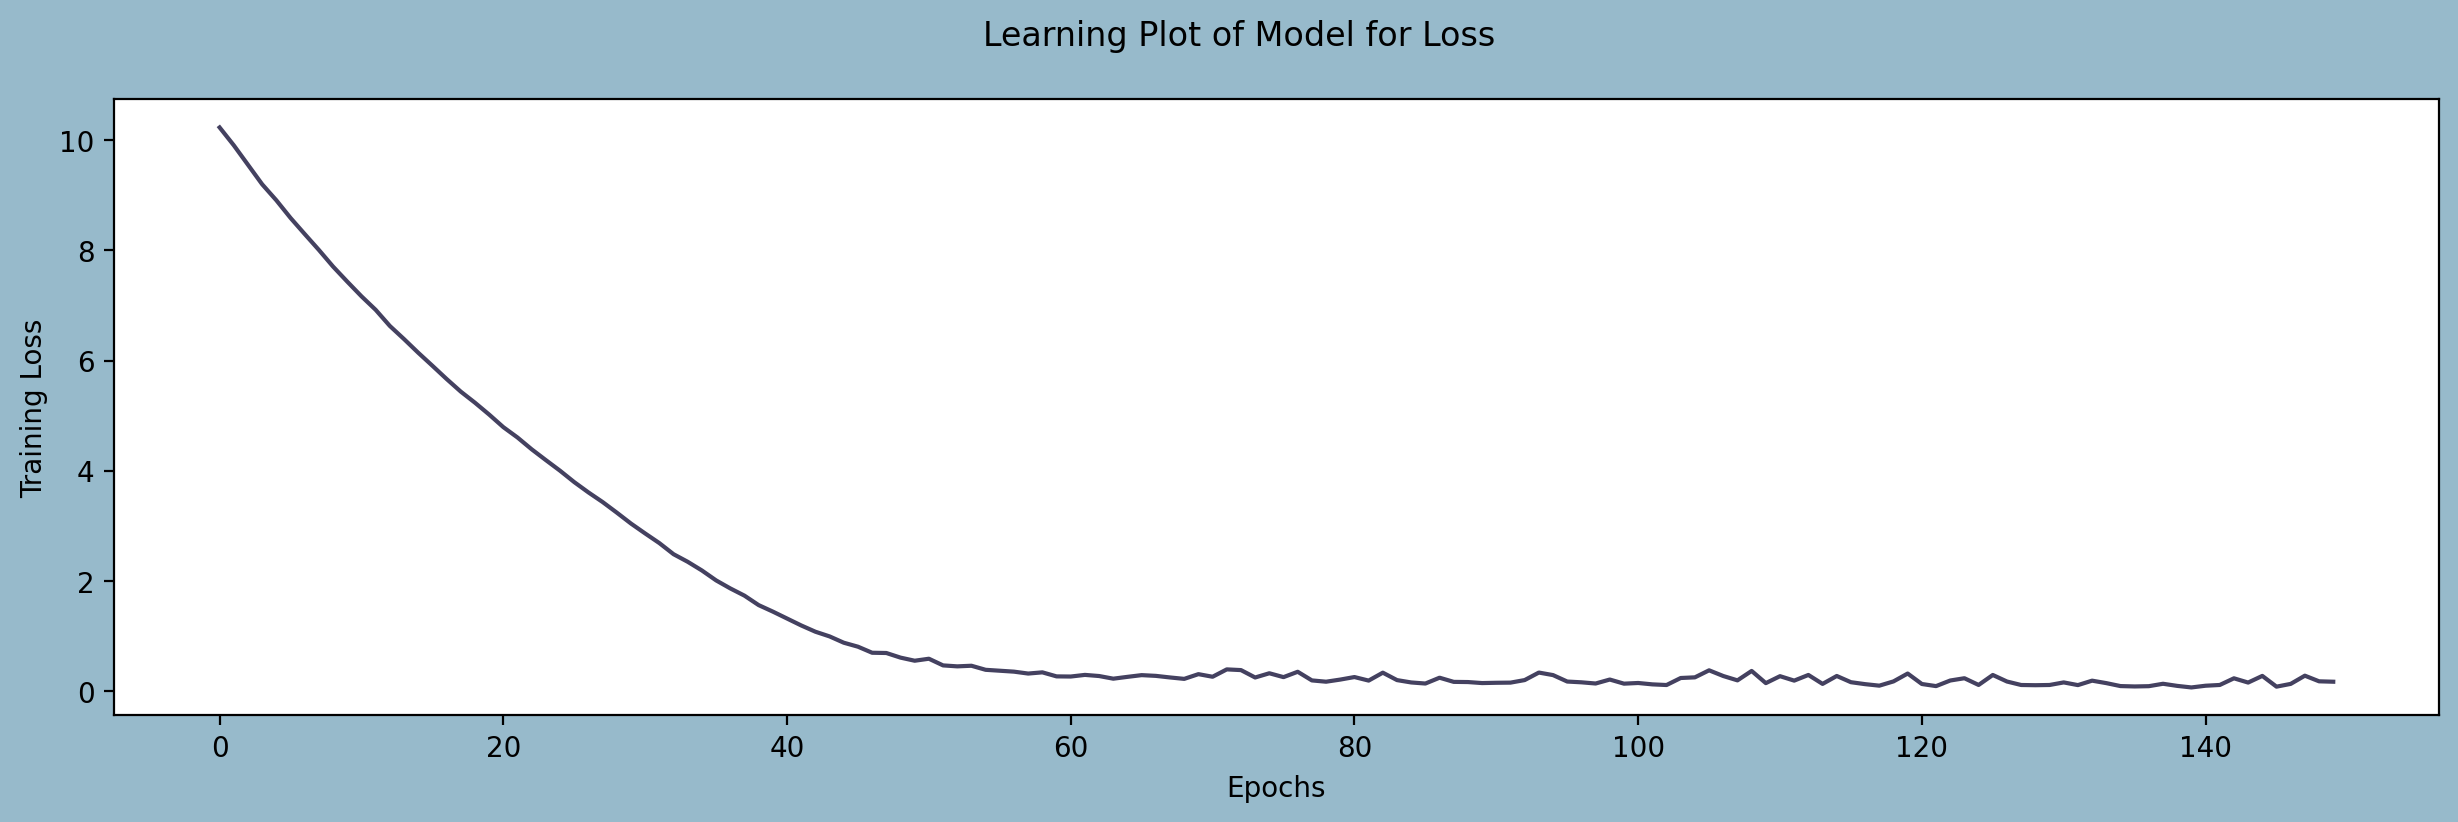

In [89]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

# Test the model

In [90]:
import numpy as np
import tensorflow as tf

def top_k_sample(predictions, k=5):
    # Reshape to 2D if needed (batch_size*seq_len, vocab_size)
    preds_reshaped = predictions.reshape(-1, predictions.shape[-1])
    
    # Get top-k indices and sample from them
    results = np.array([
        np.random.choice(
            np.argsort(p)[-k:],  # Get indices of top-k probabilities
            p=p[np.argsort(p)[-k:]]/np.sum(p[np.argsort(p)[-k:]])  # Normalize probabilities
        ) 
        for p in preds_reshaped
    ])
    
    # Reshape back to original dimensions
    return results.reshape(predictions.shape[:-1])

def generate_partition(prompt, argmodel, temperature=1.0, top_k=5):
    """
    Generate music partition from text prompt using the trained model.
    
    Args:
        prompt: Text prompt (string)
        temperature: Controls randomness 
        top_k: take top_k most likely sequences
    
    Returns:
        List of musical notes
    """

    if (top_k>L_symb):
        return f"top_k should not exceed {L_symb}"

    # Encode and pad the input text
    encoded_prompt = tokenizer.texts_to_sequences([prompt])

    
    padded_prompt = tf.keras.preprocessing.sequence.pad_sequences(
        encoded_prompt, maxlen=X_padded.shape[1], padding='post'
    )

    
    # Generate prediction from model
    predicted_sequence = argmodel.predict(padded_prompt)

    '''
    # Apply temperature sampling for creativity control
    if temperature != 1.0:
        predicted_sequence = np.log(predicted_sequence) / temperature
        predicted_sequence = np.exp(predicted_sequence)
        predicted_sequence = predicted_sequence / np.sum(predicted_sequence, axis=-1, keepdims=True)
    '''
    # Get the indices of most likely notes (give the same output every time for a given input)
    #note_indices = np.argmax(predicted_sequence, axis=-1)[0]

    # Get the top_k most likely notes
    note_indices = top_k_sample(predicted_sequence, k=top_k)[0]
    
    # Map indices back to actual notes using your reverse_mapping
    generated_notes = [reverse_mapping[idx] for idx in note_indices]
    
    # Remove any padding tokens if necessary
    # If you have a specific padding value, filter it out here
    
    return generated_notes

In [66]:
# Example usage
prompt1 = "ABBA 1979 disco dramatic fast"
prompt2 = "ABBA 1976 ballad melancholic slow"


generated_music1 = generate_partition(prompt2, model)
Melody1 = chords_n_notes(generated_music1)
Melody1.write('midi','Melody_Generated1.mid')
print(f"Generated {len(generated_music1)} notes from prompt: '{prompt2}'")
print(generated_music1)
print("\n")
generated_music2 = generate_partition(prompt1, model)
Melody2 = chords_n_notes(generated_music2)
Melody2.write('midi','Melody_Generated2.mid')
print(f"Generated {len(generated_music2)} notes from prompt: '{prompt1}'")
print(generated_music2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Generated 200 notes from prompt: 'ABBA 1976 ballad melancholic slow'
[('Rest', 0.5, 130), ('D2', 0.5, 130), ('Rest', 0.5, 130), ('C2', 0.5, 130), ('Rest', 0.5, 130), ('F1', 0.5, 130), ('Rest', 0.5, 130), ('B-1', 0.5, 130), ('Rest', 0.5, 130), ('B-1', 0.5, 130), ('G2', Fraction(5, 3), 108), ('C2', 0.5, 130), ('Rest', 0.5, 130), ('F1', 0.5, 130), ('Rest', 0.5, 130), ('F1', 0.5, 130), ('Rest', 0.5, 130), ('F1', 0.5, 130), ('Rest', 0.5, 130), ('D2', 0.5, 130), ('Rest', 0.5, 130), ('F1', 0.5, 130), ('Rest', 0.5, 130), ('F1', 0.5, 130), ('Rest', 0.5, 130), ('F1', 0.5, 130), ('Rest', 0.5, 130), ('F1', 0.5, 130), ('Rest', 0.5, 130), ('F1', 0.5, 130), ('0.4.7', Fraction(1, 3), 108), ('D2', 0.5, 130), ('Rest', 0.5, 130), ('F1', 0.5, 130), ('Rest', 0.5, 130), ('D2', 0.5, 130), ('Rest', 0.5, 130), ('D2', 0.5, 130), ('E2', 1.0, 145), ('D2', 0.5, 130), ('Rest', 0.5, 130), ('D2', 0.5, 130), ('B4', 0.5, 112), ('D2', 0.5, 130), ('Rest', 0.5, 130), ('D2', 0.5, 130), (

In [91]:
prompt = "disco fast" #fonctionne un peu
generated_music = generate_partition(prompt, model, top_k = 5)
Melody = chords_n_notes(generated_music)
Melody.write('midi','Melody_Generated.mid')
print(f"Generated {len(generated_music)} notes from prompt: '{prompt}'")
print(generated_music)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Generated 200 notes from prompt: 'disco fast'
[('Rest', 0.25, 118), ('4.7', 0.5, 118), ('Rest', 0.25, 118), ('6.9', 0.5, 118), ('4.7', 1.0, 118), ('Rest', 0.25, 118), ('7.11', 0.5, 118), ('7.11', 0.5, 118), ('Rest', 0.25, 140), ('G2', 1.0, 118), ('5.10', 1.0, 92), ('C5', 1.0, 92), ('7.11', 2.0, 118), ('2.6.9', 4.0, 140), ('Rest', 0.75, 118), ('G3', 0.5, 118), ('Rest', 0.75, 118), ('G2', 0.5, 118), ('A2', 0.5, 173.25), ('Rest', 0.25, 118), ('7.11', 0.5, 118), ('G2', 1.5, 118), ('7.11', 1.5, 118), ('Rest', 0.75, 129), ('7.11', 0.5, 118), ('Rest', 0.25, 118), ('7.11', 0.5, 118), ('Rest', 0.25, 118), ('G2', 1.0, 118), ('Rest', 1.0, 118), ('Rest', 2.5, 118), ('7.11', 0.5, 118), ('7.11', 0.5, 118), ('Rest', 0.25, 118), ('6.9', 0.5, 118), ('4.7', 0.5, 118), ('Rest', 2.0, 108), ('Rest', 0.5, 118), ('4.7', 0.5, 118), ('2.6.7', 0.5, 118), ('2.6', 2.0, 118), ('Rest', 0.5, 118), ('2.6', 1.5, 118), ('Rest', 0.25, 140), ('Rest', 0.25, 118), ('G2', 0.5, 118), ('Res

# Save model weights

In [71]:
# Save weights to file
model.save_weights('model_weightsV3.weights.h5')

# Go further : different instruments, scores, bpm...

In [ ]:
from music21 import stream, note, chord, instrument

#à tester


from music21 import stream, note, chord, instrument, tempo

def create_midi(lists_of_notes, tempo_bpm=120):
    score = stream.Score()  # Contiendra toutes les pistes
    
    # Créer un objet tempo (battements par minute)
    metronome_mark = tempo.MetronomeMark(number=tempo_bpm)
    
    for idx, notes_list in enumerate(lists_of_notes):
        part = stream.Part()  # Une partie distincte pour chaque instrument
        
        # Assigner un instrument différent par piste
        instruments = [instrument.Flute(), instrument.Guitar()]
        part.append(instruments[idx % len(instruments)])
        
        # Ajouter le tempo à la première partie
        existing_tempo = part.getElementsByClass('MetronomeMark')
        if existing_tempo:
            # Supprimer tous les tempos existants
            for tempo_obj in existing_tempo:
                part.remove(tempo_obj)
        
        # Ajouter un nouveau MetronomeMark
        metronome_mark = tempo.MetronomeMark(number=tempo_bpm)
        part.insert(0, metronome_mark)  # Ajouter le tempo au début de la partie

        offset = 0  # Gérer le timing des notes
        for i in notes_list:
            if "." in i or i.isdigit():  # Accord
                chord_notes = i.split(".")
                notes = [note.Note(int(j)) for j in chord_notes]
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                part.append(chord_snip)
            else:  # Note unique
                note_snip = note.Note(i)
                note_snip.offset = offset
                part.append(note_snip)
            
            offset += 1  # Tu peux modifier cette valeur pour créer des superpositions
            
        score.append(part)  # Ajoute la partie complète au morceau

    return score


In [ ]:
multi_instrument_midi = create_midi([generated_music1, generated_music2])

# Sauvegarder en MIDI
multi_instrument_midi.write("midi", fp="multi_instrument.mid")

# Explore MORE data

In [1]:
from music21 import converter, instrument, note, chord, tempo, meter
import pandas as pd

# Load the MIDI file
midi_file = "/kaggle/input/lakh-midi-clean/ABBA/Dancing_Queen.mid"
midi_data = converter.parse(midi_file)

# Extract metadata
print(f"Title: {midi_data.metadata.title}")
print(f"Composer: {midi_data.metadata.composer}")

# List all instruments
instruments = [part.getInstrument().instrumentName for part in midi_data.parts]
print(f"Instruments: {instruments}")

# Initialize lists to store extracted data
note_data = []

for part in midi_data.parts:
    instrument_name = part.getInstrument().instrumentName

    for element in part.flat.notesAndRests:
        if isinstance(element, note.Note):  # If it's a single note
            note_data.append({
                "Instrument": instrument_name,
                "Type": "Note",
                "Pitch": element.nameWithOctave,
                "Duration": element.quarterLength,
                "Offset": element.offset
            })
        
        elif isinstance(element, chord.Chord):  # If it's a chord
            note_data.append({
                "Instrument": instrument_name,
                "Type": "Chord",
                "Pitch": ".".join(n.nameWithOctave for n in element.notes),
                "Duration": element.quarterLength,
                "Offset": element.offset
            })
        
        elif isinstance(element, note.Rest):  # If it's a rest
            note_data.append({
                "Instrument": instrument_name,
                "Type": "Rest",
                "Pitch": "Rest",
                "Duration": element.quarterLength,
                "Offset": element.offset
            })

# Convert to DataFrame for easy viewing
df = pd.DataFrame(note_data)
df.head()  # Show the first rows


Title: None
Composer: None
Instruments: [None, None, None, None, None, None, None, None, None, None, None]


/usr/local/lib/python3.10/dist-packages/music21/stream/base.py:3689: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


,Instrument,Type,Pitch,Duration,Offset
0,None,Rest,Rest,4.0,0.0
1,None,Rest,Rest,4.0,4.0
2,None,Rest,Rest,4.0,8.0
3,None,Rest,Rest,4.0,12.0
4,None,Rest,Rest,4.0,16.0


In [14]:
# Extract key
key = midi_data.analyze('key')
print(f"Key: {key}")

# Extract tempo (if present)
for el in midi_data.flatten().getElementsByClass(tempo.MetronomeMark):
    print(f"Tempo: {el.number} BPM")

# Extract time signature
for ts in midi_data.flatten().getElementsByClass(meter.TimeSignature):
    print(f"Time Signature: {ts.ratioString}")


Key: e minor
Tempo: 120 BPM
Time Signature: 4/4


> **What will be useful :**
>  - Tempo
>  - Rests (to be encoded the same way as notes and chords)
>  - Durations 
>  - Offsets (to be adjusted in chords_n_notes based on how durations are handled)
>
> **So we'll now work with sequences of tuples of (note/chord/rest, duration, tempo)**

# Entirely made by chatgpt : (doesn't really sound better)

In [ ]:
from music21 import stream, note, chord, midi

# Create a stream for the melody, harmonies, and guitar licks
melody = stream.Stream()

# Add melody notes
melody_notes = [
    note.Note("A4", quarterLength=1),
    note.Note("B4", quarterLength=1),
    note.Note("C5", quarterLength=1),
    note.Note("E4", quarterLength=1),
    note.Note("D5", quarterLength=1),
    note.Note("E5", quarterLength=1),
    note.Note("G4", quarterLength=1),
]

melody.append(melody_notes)

# Add chords for harmony
harmony = stream.Stream()
harmony_chords = [
    chord.Chord(["C4", "E4", "A4"], quarterLength=2),
    chord.Chord(["F4", "A4", "C5"], quarterLength=2),
    chord.Chord(["G4", "B4", "D5"], quarterLength=2),
]

harmony.append(harmony_chords)

# Add guitar licks
guitar_licks = stream.Stream()
guitar_lick_notes = [
    chord.Chord(["A3", "C4", "E4", "G4"], quarterLength=1),
    chord.Chord(["F4", "A4", "C5"], quarterLength=1),
    note.Note("D5", quarterLength=0.5),
    note.Note("C5", quarterLength=0.5),
    note.Note("A4", quarterLength=1),
    note.Note("G4", quarterLength=1),
]

guitar_licks.append(guitar_lick_notes)

# Combine the melody, harmony, and guitar into one stream
full_piece = stream.Stream()
full_piece.append([melody, harmony, guitar_licks])

# Export to MIDI
full_piece.write("midi", "chatgpt.mid")

print("MIDI file saved!")
